In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
import matplotlib.gridspec as gridspec
import sklearn
import helpers
from sklearn import tree
from sklearn import ensemble
from sklearn import naive_bayes
from sklearn import svm
from sklearn import linear_model

# Credit Card Fraud Dataset

### Introduction
I've taken the data from the Kaggle Credit Card Fraud Detection dataset so we can work through it. I've tried to provide helpful structure in this notebook, and some helper functions in an external .py file.  

In this dataset there are two classes: legitimate transactions (labelled 0) and fraudulent transactions (labelled 1). The features are mostly from a principal component analysis (PCA) dimensionality reduction in order to anonymise them. Two features are not from PCA: time and amount. Don't worry about what PCA is for now. 

## Load dataset

In [2]:
dataset = pd.read_csv("data/creditcard.csv")

# Exploratory Analysis

It's important to have a good look at the dataset before you jump in. We want to understand the relative size of the classes, how well separated they are, and what the features look like.

Always handy to have a look at the raw data first. Here's the first ten rows.

In [3]:
dataset.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


## Points to consider

* Is there class imbalance? (More legitimate than fraudulent)
* What is the ratio of this class imbalance?
* Is the population of one of the classes small?
* What problems is this going to cause?

In [4]:
# Have a look at what's in the class column here 



## Feature Visualisation

* How do the marginal feature distributions look for each class? (use helpers.plot_features)
* Is there good separation?
* Is one of these going to be a problem if we just chop the dataset up as it is?

In [5]:
# If you're unsure how to use matplotlib (or don't want to spend time on this) 
# there's a function in helpers.py you can use: helpers.plot_features(dataset,13,19)
# These marginal distributions are normalised to unity. Red is fraudulent, black is normal. 
# If its too big for your screen, adjust the numbers







# Data Preparation

### Train/validation/test split

Classes need to be sampled independently to ensure that they are similarly-distributed between the training and test sets. If their distributions don't match we're not going to get a good measurement of performance from the test set or a representative training.

I've done this for you with a function in helpers called train_test_split. This is so we're all working from the same split and it's easier to compare results. Shouldn't normally matter much but the fraud class is pretty low-stats. We're going to load train and test from CSVs in data/



In [6]:
# Load pre-prepared training dataset we'll look at test set later
train = np.load('data/train.npy')
X_train = train[:,:-1] #Features
y_train = train[:,-1]  #Labels

### Weighting

Some algorithms might need weighting if there's a class imbalance.
You can try this out by passing the array below as the sample_weight arg during training. This can help or hinder the performance of your algorithm.

In [7]:
# Calculate sample weights for class balancing
n_class1 = train[:,-1].sum()
n_class0 = train.shape[0]-n_class1
weight = n_class0/n_class1
weights = np.ones(train.shape[0])
weights[np.where(train[:,-1]==1)[0]] = weight

# Training a Classifier

Let's actually do some machine learning. All sklearn algorithms implement the same interface. You use .fit(features,labels) method with the training set features and labels as args. XGBoost also has a class that implements this, but typically you wouldn't work that way with the XGBoost library.

## Machine Learning Algorithms

The dictionary below contains a bunch of different algorithms for you to try out.

References for each of the Algorithms:
* XGBoost Classifier: https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
* Decision Tree: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
* Adaboost Trees: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
* Gaussian Naive Bayes: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB
* Random Forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* Logistic Regressor: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

These will tell you the default hyperparameters. Refer back to these when you want to experiment with these. Use the defaults for now. 

In [8]:
algo_zoo = {
    'XGradientBoostTrees':xgboost.XGBClassifier,
    'DecisionTree': tree.DecisionTreeClassifier,
    'AdaBoostTrees': ensemble.AdaBoostClassifier,
    'NaiveBayes':naive_bayes.GaussianNB,
    'Mike':ensemble.RandomForestClassifier,
    'LogisticRegressor':linear_model.LogisticRegression
}

In [9]:
# Pick an algorithm object creator from algo Zoo and call it
# e.g. clf = algo_zoo['NaiveBayes']()
# Make sure you have the () 


In [10]:
# Train it with clf.fit(X_train,y_train)


# Evaluating Your Classifier's Performance

Now we use the model on the held-out data (the test set) and evaluate the predictions it makes with the AUROC (Area Under the Reciever Operating Characterisic curve)

In [11]:
# Load pre-prepared test dataset
test = np.load('data/test.npy')
X_test = test[:,:-1] #Features
y_test = test[:,-1]  #Labels

In [12]:
# Make predictions on test set. Column 1 is prob of class 1 (fraud)
# Predict proba will give a score between 0 and 1. Some algos do this better than others.
# e.g. default decision tree will just be 0 or 1

# You can do it like this: test_prob = clf.predict_proba(X_test)[:,1]

### Visualise the score distributions of the classes

The helper function evaluate_model produces a plot of the score (prob) outputs of the trained model on the left, and a ROC curve on the right. Use this to evaluate your trained model. 

In [13]:
# Call it like this: helpers.evaluate_model(test_prob,y_test)



### An aside: ROC curves and score distributions
This is a little demo so you can get an idea for how ROC curves work and why they're a handy metric for a binary classifier.

Try changing the d_mu variable which will separate out the two class distributions. What happens to the ROC curve as we go from complete overlap to disjoint? Try 0.01, 0.05 etc.

/Library/Python/2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


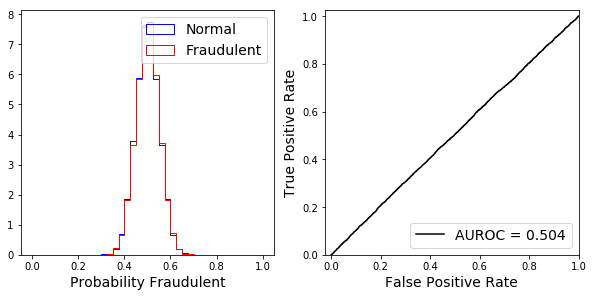

In [14]:
d_mu = 0.0
size = 10000
class_0_scores = np.random.normal(loc=0.5-d_mu,scale=0.05,size=[size,1])
class_0_labels = np.zeros([size,1])
class_1_scores = np.random.normal(loc=0.5+d_mu,scale=0.05,size=[size,1])
class_1_labels = np.ones([size,1])

helpers.evaluate_model(
    np.vstack([class_0_scores,class_1_scores]),
    np.vstack([class_0_labels,class_1_labels])
)

## Where next?

You can provide arguments to the classifier constructors that set their hyperparameters.
You should tune these by using a validation set taken from the training set, or cross-validation (taking care that the variance is low as well as having a good mean). Try lots of stuff out! See how high a test set score you can get.

### Stuff to try

* Make a validation set for hyperparameter optimisation, or do cross validation, taking care that the class ratio is kept the same so the samples are representative of each other. 
* Try different hyperparameters for your algorithm. How does its AUROC performance change? The sklearn function for computing this can be found in helpers.py
* Try some other metrics for algorithm performance. Why is accuracy a bad measure?
* What are the pros and cons of the different algorithms?
* Try removing features
* What are the feature importances? (if your model does them)